# Querying an SQL Database

In this exercise, you'll build a Haystack pipeline that converts a natural language query into SQL and fetches the result from a database.

Later on, you'll use this pipeline as a tool for the healthcare agent.

![Haystack pipeline](images/pipeline.png)

### ❗️ Note: Run the **hidden cell** below to initialize the agent, before running the rest of the code. ❗️ 

In [1]:
!pip install -q haystack-ai


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


### 🧱 Populating the SQL Database
Start by creating an SQLite database using a synthetic dataset of dermatology patient records.


In [2]:
import pandas as pd
import sqlite3

# Read the CSV file into a pandas DataFrame
df = pd.read_csv("dermatology_patient_data.csv", encoding="utf-8-sig", delimiter=";")

# Create a connection to a new SQLite database named "patient_data.db"
db_connection = sqlite3.connect("patient_data.db")

# Write the contents of the DataFrame to a new table named "patients"
df.to_sql("patients", db_connection, if_exists="replace", index=False)

# Close the database connection
db_connection.close()

### 🧩 Creating the Custom SQLConnector Component
This component will extract SQL query from the LLM's output, execute it on the database, and return the results.

In [3]:
import re
import sqlite3
import pandas as pd
from typing import List

from haystack import component
from haystack.dataclasses import ChatMessage

@component
class SQLConnector:
    def __init__(self, sql_database: str):
        # Initialize a connection to the SQLite database
        self.connection = sqlite3.connect(sql_database, check_same_thread=False)

    @component.output_types(results=List[str])
    def run(self, llm_replies: List[ChatMessage]):
        results = []
        pattern = r"```sql\s*([\s\S]+?)```" # # Regex pattern to extract SQL code from Markdown-style code blocks: ```sql ... ```

        for message in llm_replies:
            extracted = re.findall(pattern, message.text)
            if not extracted:
                results.append("No SQL code found.")
                continue

            sql_to_run = " ".join(extracted[0].splitlines()).strip()
            try:
                result = pd.read_sql(sql_to_run, self.connection) # Execute the SQL query and read the results into a DataFrame
                results.append(str(result))

            except Exception as e:
                results.append(f"Error: {e}")

        return {"results": results}

### 🔧 Building the Pipeline
Now you'll connect three components into a pipeline:
* A `ChatPromptBuilder` to render the prompt with SQL table information for SQL query generation
* An `OpenAIChatGenerator` to generate SQL query
* Your custom `SQLConnector` to run the query

In [5]:
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator

query_to_sql_prompt = """
You are an expert SQL assistant. Given the following table structure:

Table name: patients

Columns:
- patient_id (TEXT)
- age (INTEGER)
- gender (TEXT)
- condition (TEXT)  // Dermatological diagnosis (e.g., Psoriasis, Acne)
- medication (TEXT)  // Treatment corresponding to the condition
- skin_type (TEXT)  // Sensitive, Normal, Dry, Combination, Oily
- last_visit_date (DATE)
- smoker (TEXT)  // Yes or No
- alcohol_use (TEXT)  // None, Light, Moderate, Heavy
- BMI (FLOAT)  // Body Mass Index (e.g., 23.1)
- occupation (TEXT)  // Profession or employment status
- allergies (TEXT)  // Known non-sensitive allergies (e.g., Pollen, Latex, None)
- comorbid_condition (TEXT)  // Other health conditions (e.g., Asthma, Hypertension, None)

Write an SQL query to for this user query: {{query}}.

Only return the SQL query, nothing else.
"""

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt_builder", ChatPromptBuilder(template=[ChatMessage.from_user(query_to_sql_prompt)], required_variables="*"))
sql_pipeline.add_component("chat_generator", OpenAIChatGenerator(model="gpt-4o-mini"))
sql_pipeline.add_component("sql_connector", SQLConnector('patient_data.db'))

sql_pipeline.connect("prompt_builder", "chat_generator")
sql_pipeline.connect("chat_generator.replies", "sql_connector.llm_replies")

🚅 Components
  - prompt_builder: ChatPromptBuilder
  - chat_generator: OpenAIChatGenerator
  - sql_connector: SQLConnector
🛤️ Connections
  - prompt_builder.prompt -> chat_generator.messages (List[ChatMessage])
  - chat_generator.replies -> sql_connector.llm_replies (List[ChatMessage])

### 🖼️ Visualizing the Pipeline

You can visualize the full component graph to confirm the data flow.

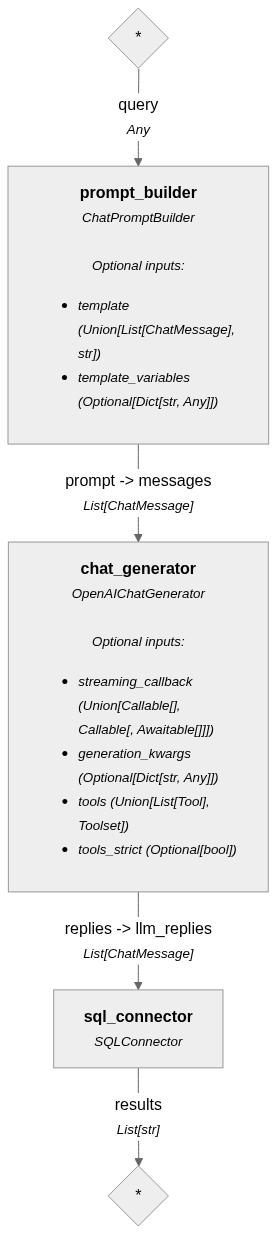

In [6]:
sql_pipeline.show()

### ▶️ Running the Pipeline
Send a natural language question through the pipeline.
The LLM will generate an SQL query, and the custom component will run it.

In [7]:
pipeline_result = sql_pipeline.run({"query":"What's the most common diagnosis of patients older than 60?"}, include_outputs_from={"chat_generator"})

### 🧾 Inspecting the Results
Print the actual query result fetched from the database:

In [8]:
print(pipeline_result["sql_connector"]["results"][0])

                  condition  diagnosis_count
0  Lichen Simplex Chronicus                5


And view the SQL query that was generated:

In [9]:
print(pipeline_result["chat_generator"]["replies"][0].text)

```sql
SELECT condition, COUNT(*) as diagnosis_count
FROM patients
WHERE age > 60
GROUP BY condition
ORDER BY diagnosis_count DESC
LIMIT 1;
```
